In [16]:
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
DATAPATH = './data/games.csv'

In [18]:
games = pd.read_csv(DATAPATH)

In [19]:
games.dtypes

Unnamed: 0             int64
SEASON_ID              int64
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_NAME             object
GAME_ID                int64
GAME_DATE             object
MATCHUP               object
WL                    object
MIN                    int64
PTS                    int64
FGM                    int64
FGA                    int64
FG_PCT               float64
FG3M                   int64
FG3A                   int64
FG3_PCT              float64
FTM                    int64
FTA                    int64
FT_PCT               float64
OREB                   int64
DREB                   int64
REB                    int64
AST                    int64
STL                    int64
BLK                    int64
TOV                    int64
PF                     int64
PLUS_MINUS           float64
dtype: object

In [20]:
games = games.drop(['Unnamed: 0'], axis=1)

In [21]:
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22019,1610612748,MIA,Miami Heat,21900970,2020-03-11,MIA vs. CHA,L,239,98,...,0.833,9,27,36,32,8,5,14,17,-13.0
1,22019,1610612743,DEN,Denver Nuggets,21900973,2020-03-11,DEN @ DAL,L,240,97,...,0.625,3,37,40,23,6,4,15,20,-7.8
2,22019,1610612752,NYK,New York Knicks,21900969,2020-03-11,NYK @ ATL,W,264,136,...,0.735,6,41,47,32,14,9,12,23,0.0
3,22019,1610612742,DAL,Dallas Mavericks,21900973,2020-03-11,DAL vs. DEN,W,240,113,...,0.739,13,39,52,23,9,2,10,14,8.0
4,22019,1610612765,DET,Detroit Pistons,21900971,2020-03-11,DET @ PHI,L,241,106,...,0.680,6,26,32,25,10,3,8,24,-14.2


In [22]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('WL')
#     ds = tf.data.Dataset.from_tensor_slices((dataframe.values, labels.values))
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [23]:
games.pop('SEASON_ID')
games.pop('TEAM_ID')
games.pop('GAME_ID')
games.pop('TEAM_NAME')

0                Miami Heat
1            Denver Nuggets
2           New York Knicks
3          Dallas Mavericks
4           Detroit Pistons
                ...        
29995        Boston Celtics
29996    Los Angeles Lakers
29997         Atlanta Hawks
29998      Dallas Mavericks
29999        Denver Nuggets
Name: TEAM_NAME, Length: 30000, dtype: object

In [24]:
feature_columns = []
obj_columns = ['TEAM_ABBREVIATION', 'GAME_DATE', 'MATCHUP', 'WL']
#numeric columns
for i in obj_columns:
    games[i] = pd.Categorical(games[i])
    games[i] = games[i].cat.codes 
for header in games.columns:
    games[header] = games[header].astype('float64')
    if header != 'WL':
        feature_columns.append(feature_column.numeric_column(header))

In [25]:
games.dtypes

TEAM_ABBREVIATION    float64
GAME_DATE            float64
MATCHUP              float64
WL                   float64
MIN                  float64
PTS                  float64
FGM                  float64
FGA                  float64
FG_PCT               float64
FG3M                 float64
FG3A                 float64
FG3_PCT              float64
FTM                  float64
FTA                  float64
FT_PCT               float64
OREB                 float64
DREB                 float64
REB                  float64
AST                  float64
STL                  float64
BLK                  float64
TOV                  float64
PF                   float64
PLUS_MINUS           float64
dtype: object

In [26]:
games.head(n=250)

,TEAM_ABBREVIATION,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,39.0,2427.0,1050.0,0.0,239.0,98.0,39.0,84.0,0.464,15.0,...,0.833,9.0,27.0,36.0,32.0,8.0,5.0,14.0,17.0,-13.0
1,16.0,2427.0,465.0,0.0,240.0,97.0,39.0,83.0,0.470,14.0,...,0.625,3.0,37.0,40.0,23.0,6.0,4.0,15.0,20.0,-7.8
2,49.0,2427.0,1395.0,1.0,264.0,136.0,50.0,94.0,0.532,11.0,...,0.735,6.0,41.0,47.0,32.0,14.0,9.0,12.0,23.0,0.0
3,15.0,2427.0,434.0,1.0,240.0,113.0,42.0,92.0,0.457,12.0,...,0.739,13.0,39.0,52.0,23.0,9.0,2.0,10.0,14.0,8.0
4,17.0,2427.0,546.0,0.0,241.0,106.0,39.0,84.0,0.464,11.0,...,0.680,6.0,26.0,32.0,25.0,10.0,3.0,8.0,24.0,-14.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,41.0,2411.0,1147.0,0.0,239.0,123.0,42.0,95.0,0.442,15.0,...,0.706,7.0,35.0,42.0,16.0,4.0,6.0,11.0,22.0,-16.0
246,38.0,2411.0,961.0,0.0,241.0,97.0,37.0,89.0,0.416,7.0,...,0.727,11.0,34.0,45.0,20.0,6.0,7.0,13.0,18.0,-27.0
247,14.0,2411.0,371.0,1.0,265.0,125.0,43.0,97.0,0.443,14.0,...,0.735,13.0,40.0,53.0,25.0,8.0,6.0,12.0,20.0,6.0
248,48.0,2410.0,1346.0,1.0,239.0,115.0,46.0,98.0,0.469,17.0,...,0.462,14.0,38.0,52.0,34.0,7.0,5.0,13.0,15.0,14.0


In [27]:
games = games.dropna()

In [28]:
print(feature_columns)

[NumericColumn(key='TEAM_ABBREVIATION', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='GAME_DATE', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='MATCHUP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='MIN', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PTS', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='FGM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='FGA', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='FG_PCT', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='FG3M', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='FG3A', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericCol

In [29]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
def get_compiled_model():
  model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [30]:
train, test = train_test_split(games, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

21596 train examples
5400 validation examples
3000 test examples


In [31]:
batch_size = 128
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [33]:
model = get_compiled_model()
history = model.fit(train_ds, epochs=20, callbacks=[es,mc], validation_data=val_ds)
y_pred = model.predict(val_ds).round()
y_act = np.asarray(val['WL'])
y_act = y_act.astype('float64')
y_act = np.reshape(y_act, y_pred.shape)
print('Precision= ', precision_score(y_act, y_pred , average="macro", labels=np.unique(y_pred)))
print('Recall= ', recall_score(y_act, y_pred , average="macro", labels=np.unique(y_pred)))
print('Val_Accuracy= ', history.history['val_accuracy'][-1])
print('Val_Loss= ', history.history['val_loss'][-1])
print('Accuracy= ', history.history['accuracy'][-1])
print('Loss= ', history.history['loss'][-1])

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

167/169 [============================>.] - ETA: 0s - loss: 0.6089 - accuracy: 0.7961
Epoch 00001: val_accuracy improved from -inf to 0.83296, saving model to best_model.hdf5
169/169 [==============================] - 1s 5ms/step - loss: 0.6082 - accuracy: 0.7973 - val_loss: 0.5814 - val_accuracy: 0.8330
Epoch 2/20
154/169 [==========================>...] - ETA: 0s - loss: 0.5339 - accuracy: 0.9424
Epoch 00002: val_accuracy improved from 0.83296 to 0.97907, saving model to best_model.hdf5
169/

In [25]:
import sys
np.set_printoptions(threshold=sys.maxsize)
y_pred = model.predict(test_ds)
for i, j in zip(y_pred, test['WL']):
    print('predicted: ', i, 'actual: ', j)

predicted:  [2.3305105e-05] actual:  0.0
predicted:  [2.2680073e-05] actual:  0.0
predicted:  [2.2845006e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.2221142e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1867132e-05] actual:  0.0
predicted:  [3.3917102e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.2008117e-05] actual:  0.0
predicted:  [2.2167318e-05] actual:  0.0
predicted:  [0.9999753] actual:  1.0
predicted:  [0.9999145] actual:  1.0
predicted:  [4.0666997e-05] actual:  0.0
predicted:  [2.2016682e-05] actual:  0.0
predicted:  [2.184206e-05] actual:  0.0
predicted:  [2.184508e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.1864817e-05] actual:  0.0
predicted:  [0.9997118] actual:  1.0
predicted:  [2.2785043e-05] actual:  0.0
predicted:  [0.9998018] actual:  1.0
predicted:  [2.1967939e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99

predicted:  [2.2031383e-05] actual:  0.0
predicted:  [2.2553853e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.1970201e-05] actual:  0.0
predicted:  [0.9999641] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99992347] actual:  1.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.1871741e-05] actual:  0.0
predicted:  [2.2080667e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.224975e-05] actual:  0.0
predicted:  [2.195416e-05] actual:  0.0
predicted:  [2.6185071e-05] actual:  0.0
predicted:  [2.21707e-05] actual:  0.0
predicted:  [0.9999366] actual:  1.0
predicted:  [0.00058174] actual:  0.0
predicted:  [2.211356e-05] actual:  0.0
predicted:  [2.2000184e-05] actual:  0.0
predicted:  [2.2091239e-05] actual:  0.0
predicted:  [2.638923e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [5.787739e-05] actual:  0.0
predicted:  [0.9999746]

predicted:  [2.2222754e-05] actual:  0.0
predicted:  [2.2012357e-05] actual:  0.0
predicted:  [0.98856634] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1865817e-05] actual:  0.0
predicted:  [2.2018152e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1902424e-05] actual:  0.0
predicted:  [0.9999746] actual:  1.0
predicted:  [0.9999747] actual:  1.0
predicted:  [3.0756702e-05] actual:  0.0
predicted:  [2.1850727e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.00040246] actual:  0.0
predicted:  [2.183452e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.1915503e-05] actual:  0.0
predicted:  [2.2081907e-05] actual:  0.0
predicted:  [2.1866923e-05] actual:  0.0
predicted:  [2.1906435e-05] actual:  0.0
predicted:  [2.6199084e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1995695e-05] actual:  0.0
predicted:  [2.181119e-05] actual:  0.0
predicted:  [2.3429586e-05] actual:  0.0
predicted:

predicted:  [0.9999758] actual:  1.0
predicted:  [2.1891397e-05] actual:  0.0
predicted:  [2.3638104e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99995136] actual:  1.0
predicted:  [2.2101332e-05] actual:  0.0
predicted:  [2.1824902e-05] actual:  0.0
predicted:  [2.1923823e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.3039442e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1920017e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.1870032e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1870614e-05] actual:  0.0
predicted:  [0.99988663] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.8176675e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999733] actual:  1.0
predicted:  [0.99996924] actual:  1.0
predicted:  [5.085301e-05] actual:  0.0
predicted:  [2.3219764e-05] 

predicted:  [0.99997485] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.482807e-05] actual:  0.0
predicted:  [2.4026076e-05] actual:  0.0
predicted:  [0.9999598] actual:  1.0
predicted:  [2.2120943e-05] actual:  0.0
predicted:  [2.2669865e-05] actual:  0.0
predicted:  [2.195862e-05] actual:  0.0
predicted:  [0.9977563] actual:  1.0
predicted:  [0.00076952] actual:  0.0
predicted:  [2.1869571e-05] actual:  0.0
predicted:  [2.1966893e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.4334864e-05] actual:  0.0
predicted:  [2.2082078e-05] actual:  0.0
predicted:  [2.241728e-05] actual:  0.0
predicted:  [2.1839685e-05] actual:  0.0
predicted:  [2.2400227e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.2081991e-05] actual:  0.0
predicted:  [2.1879043e-05] actual:  0.0
predicted:  [2.3707162e-05] actual:  0.0
predicted:  [2.1905222e-05] actual:  0.0
predicted:  [2.6886073e-05] actual:  0.0
predicted:  [0.9999696] actual:  1.0
predicte

predicted:  [2.1855893e-05] actual:  0.0
predicted:  [2.2798366e-05] actual:  0.0
predicted:  [0.99995923] actual:  1.0
predicted:  [0.99997425] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1898977e-05] actual:  0.0
predicted:  [2.1825483e-05] actual:  0.0
predicted:  [0.9999726] actual:  1.0
predicted:  [2.2567041e-05] actual:  0.0
predicted:  [2.192926e-05] actual:  0.0
predicted:  [2.261187e-05] actual:  0.0
predicted:  [2.1881651e-05] actual:  0.0
predicted:  [2.1924783e-05] actual:  0.0
predicted:  [0.00010265] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99997556] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.351052e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.00032376] actual:  0.0
predicted:  [0.00015728] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.3768916e-05] actual:  0.0
predicted:  [2.1922255e-05] 

predicted:  [0.9999751] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.2351445e-05] actual:  0.0
predicted:  [0.9998142] actual:  1.0
predicted:  [2.1823384e-05] actual:  0.0
predicted:  [2.2203114e-05] actual:  0.0
predicted:  [2.217142e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.2066415e-05] actual:  0.0
predicted:  [0.99997556] actual:  1.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.6603404e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.7003374e-05] actual:  0.0
predicted:  [2.8056258e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1907772e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99997425] actual:  1.0
predicted:  [0.9999722] actual:  1.0
predicted:  [0.9999752] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999734] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99997485] actual:  1.0

predicted:  [0.9999759] actual:  1.0
predicted:  [2.2638129e-05] actual:  0.0
predicted:  [2.1856937e-05] actual:  0.0
predicted:  [2.2023232e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99997556] actual:  1.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.204883e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.239886e-05] actual:  0.0
predicted:  [2.2122587e-05] actual:  0.0
predicted:  [2.1827691e-05] actual:  0.0
predicted:  [2.1835018e-05] actual:  0.0
predicted:  [0.9765802] actual:  1.0
predicted:  [2.1912369e-05] actual:  0.0
predicted:  [0.9999709] actual:  1.0
predicted:  [2.1897577e-05] actual:  0.0
predicted:  [2.1964464e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999751] actual:  1.0
predicted:  [0.9999652] actual:  1.0
predicted:  [2.1914582e-05] actual:  0.0
predicted:  [0.9999672] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999759] act

predicted:  [2.1955793e-05] actual:  0.0
predicted:  [2.2145598e-05] actual:  0.0
predicted:  [3.1335472e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999105] actual:  1.0
predicted:  [0.9999716] actual:  1.0
predicted:  [3.3617303e-05] actual:  0.0
predicted:  [2.2197715e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1979067e-05] actual:  0.0
predicted:  [2.2158356e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.00013417] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1926373e-05] actual:  0.0
predicted:  [2.2600294e-05] actual:  0.0
predicted:  [2.1874745e-05] actual:  0.0
predicted:  [2.2017752e-05] actual:  0.0
predicted:  [2.2071108e-05] actual:  0.0
predicted:  [2.2092629e-05] actual:  0.0
predicted:  [2.193955e-05] actual:  0.0
predicted:  [2.4421604e-05] actual:  0.0
predicted:  [0.99997556] actual:  1.0
predicted:  [2

predicted:  [0.9999757] actual:  1.0
predicted:  [0.99997425] actual:  1.0
predicted:  [2.6651294e-05] actual:  0.0
predicted:  [2.2026341e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1874765e-05] actual:  0.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.2178228e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.2047821e-05] actual:  0.0
predicted:  [0.99997556] actual:  1.0
predicted:  [2.5987698e-05] actual:  0.0
predicted:  [0.99997294] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1911197e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.2243446e-05] actual:  0.0
predicted:  [2.18416e-05] actual:  0.0
predicted:  [3.0974577e-05] actual:  0.0
predicted:  [2.3607758e-05] actual:  0.0
predicted:  [2.2113287e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.2007654e-05] actual:  0.0
predicted:  [2.18866

predicted:  [0.99996936] actual:  1.0
predicted:  [0.99997413] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99987996] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.2084816e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.2191305e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.3246195e-05] actual:  0.0
predicted:  [2.1845433e-05] actual:  0.0
predicted:  [0.0004328] actual:  0.0
predicted:  [0.9999752] actual:  1.0
predicted:  [3.8786326e-05] actual:  0.0
predicted:  [2.1986089e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1811418e-05] actual:  0.0
predicted:  [0.9999739] actual:  1.0
predicted:  [2.3079245e-05] actual:  0.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.1910384e-05] actual:  0.0
predicted:  [2.1853102e-05] actual:  0.0
predicted:  [2.2424465e-05] actual:  0.0
predicted:  [2.2789627e-05] actual:  0.0
predicted:  [0.9999759

predicted:  [3.1598855e-05] actual:  0.0
predicted:  [2.2330396e-05] actual:  0.0
predicted:  [0.99993694] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.2225444e-05] actual:  0.0
predicted:  [0.9999739] actual:  1.0
predicted:  [2.2582326e-05] actual:  0.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.1901045e-05] actual:  0.0
predicted:  [2.5401594e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.2161083e-05] actual:  0.0
predicted:  [0.9997689] actual:  1.0
predicted:  [2.1906559e-05] actual:  0.0
predicted:  [2.286905e-05] actual:  0.0
predicted:  [2.2193355e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.2052993e-05] actual:  0.0
predicted:  [0.999974] actual:  1.0
predicted:  [2.2902486e-05] actual:  0.0
predicted:  [2.1824299e-05] actual:  0.0
predicted:  [2.191512

predicted:  [4.4504297e-05] actual:  0.0
predicted:  [2.185581e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9878786] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.1901671e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.6253932e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.229754e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.2056402e-05] actual:  0.0
predicted:  [2.231207e-05] actual:  0.0
predicted:  [2.1866214e-05] actual:  0.0
predicted:  [0.9995258] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99997437] actual:  1.0
predicted:  [0.00014646] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.1958977e-05] actual:  0.0
p

predicted:  [0.99997413] actual:  1.0
predicted:  [2.1879292e-05] actual:  0.0
predicted:  [0.99997413] actual:  1.0
predicted:  [0.00017585] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.2005472e-05] actual:  0.0
predicted:  [2.7172526e-05] actual:  0.0
predicted:  [2.2350678e-05] actual:  0.0
predicted:  [2.1996493e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.215339e-05] actual:  0.0
predicted:  [2.18644e-05] actual:  0.0
predicted:  [2.1824984e-05] actual:  0.0
predicted:  [2.1874535e-05] actual:  0.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.3731138e-05] actual:  0.0
predicted:  [2.1880523e-05] actual:  0.0
predicted:  [2.2452603e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1950265e-05] actual:  0.0
predicted:  [0.9999269] actual:  1.0
predicted:  [2.2196276e-05] actual:  0.0
predicted:  [2.3488108e-05] actual:  0.0
predicted:  [2

predicted:  [0.9999747] actual:  1.0
predicted:  [2.183431e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.2247625e-05] actual:  0.0
predicted:  [0.9999752] actual:  1.0
predicted:  [2.1841017e-05] actual:  0.0
predicted:  [2.193018e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.187124e-05] actual:  0.0
predicted:  [0.99997413] actual:  1.0
predicted:  [0.00055209] actual:  1.0
predicted:  [2.1831811e-05] actual:  0.0
predicted:  [2.231077e-05] actual:  0.0
predicted:  [2.704301e-05] actual:  0.0
predicted:  [2.2108248e-05] actual:  0.0
predicted:  [0.9999752] actual:  1.0
predicted:  [2.186144e-05] actual:  0.0
predicted:  [2.1905766e-05] actual:  0.0
predicted:  [2.291651e-05] actual:  0.0
predicted:  [0.9998853] actual:  1.0
predicted:  [0.9971433] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999645] actual:  1.0
predicted:  [2.2171294e-05] actual:  0.0
predicted:  [2.6326767e-05] 

predicted:  [0.99997544] actual:  1.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.1833437e-05] actual:  0.0
predicted:  [2.215263e-05] actual:  0.0
predicted:  [2.1873118e-05] actual:  0.0
predicted:  [2.2041007e-05] actual:  0.0
predicted:  [2.1894677e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1874284e-05] actual:  0.0
predicted:  [2.1935472e-05] actual:  0.0
predicted:  [2.2178652e-05] actual:  0.0
predicted:  [4.2056596e-05] actual:  0.0
predicted:  [2.1849935e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999747] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.6518901e-05] actual:  0.0
predicted:  [0.99997497] actual:  1.0
predicted:  [3.300133e-05] actual:  0.0
predicted:  [2.1857812e-05] actual:  0.0
predicted:  [2.582772e-05] actual:  0.0
predicted:  [2.2473147e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99991477] actual:  1.0
predicted:  [2.

predicted:  [0.9999759] actual:  1.0
predicted:  [0.9997807] actual:  1.0
predicted:  [0.999943] actual:  1.0
predicted:  [2.2855837e-05] actual:  0.0
predicted:  [2.190938e-05] actual:  0.0
predicted:  [4.0891657e-05] actual:  0.0
predicted:  [2.5390356e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.5625535e-05] actual:  0.0
predicted:  [0.9999753] actual:  1.0
predicted:  [2.1923739e-05] actual:  0.0
predicted:  [0.99994826] actual:  1.0
predicted:  [2.1865484e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.2194394e-05] actual:  0.0
predicted:  [2.1916003e-05] actual:  0.0
predicted:  [0.9999746] actual:  1.0
predicted:  [2.2219829e-05] actual:  0.0
predicted:  [2.5222604e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.229401e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.761379e-05] a

predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99997556] actual:  1.0
predicted:  [2.181895e-05] actual:  0.0
predicted:  [2.1843141e-05] actual:  0.0
predicted:  [0.9999697] actual:  1.0
predicted:  [2.1821093e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.351904e-05] actual:  0.0
predicted:  [2.223702e-05] actual:  0.0
predicted:  [0.99997234] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.9999727] actual:  1.0
predicted:  [2.1839769e-05] actual:  0.0
predicted:  [2.218081e-05] actual:  0.0
predicted:  [2.2113603e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1960986e-05] actual:  0.0
predicted:  [2.4004685e-05] actual:  0.0
predicted:  [2.4085906e-05] actual:  0.0
predicted:  [0.9999745] actual:  1.0
predicted:  [0.9999732] actual:  1.0
predicted:  [2.1909109e-05] actual:  0.0
predicted:  [0.9999747] actual:  1.0
predicted:  [2.2043616e-05] actual:  0.0
predicted:  [0.9999759] a

predicted:  [0.9999757] actual:  1.0
predicted:  [2.655342e-05] actual:  0.0
predicted:  [2.967979e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.2544542e-05] actual:  0.0
predicted:  [2.2151553e-05] actual:  0.0
predicted:  [0.9999734] actual:  1.0
predicted:  [2.190424e-05] actual:  0.0
predicted:  [0.99991465] actual:  1.0
predicted:  [2.2060334e-05] actual:  0.0
predicted:  [3.4231518e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.9999732] actual:  1.0
predicted:  [2.1894653e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.210264e-05] actual:  0.0
predicted:  [0.00027194] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [0.99997187] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [8.248253e-05] actual:  0.0
predicted:  [5.7526384e-05] actual:  0.0
predicted:  [2.1959897e-05] actual:  0.0
predicted:  [2.3000981e-05] actual:  0.0
predicted:  [2.1831273e-05] actual:  0.0
predicted:  [3.30827

predicted:  [0.99996316] actual:  1.0
predicted:  [0.99997425] actual:  1.0
predicted:  [2.1903132e-05] actual:  0.0
predicted:  [0.99997544] actual:  1.0
predicted:  [2.1897913e-05] actual:  0.0
predicted:  [2.1859687e-05] actual:  0.0
predicted:  [2.2260889e-05] actual:  0.0
predicted:  [2.1847663e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.4180772e-05] actual:  0.0
predicted:  [2.3395825e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99997485] actual:  1.0
predicted:  [2.1815496e-05] actual:  0.0
predicted:  [0.99997556] actual:  1.0
predicted:  [2.2000395e-05] actual:  0.0
predicted:  [0.9999645] actual:  1.0
predicted:  [2.1921001e-05] actual:  0.0
predicted:  [2.1904532e-05] actual:  0.0
predicted:  [0.9999759] actual:  1.0
predicted:  [9.573865e-05] actual:  0.0
predicted:  [2.1944657e-05] actual:  0.0
predicted:  [2.2061744e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.1899981e-05] actual:  0.0
predicted: 

predicted:  [2.1903676e-05] actual:  0.0
predicted:  [2.188092e-05] actual:  0.0
predicted:  [2.938966e-05] actual:  0.0
predicted:  [7.412627e-05] actual:  0.0
predicted:  [2.1839038e-05] actual:  0.0
predicted:  [0.99997103] actual:  1.0
predicted:  [0.00314875] actual:  0.0
predicted:  [0.9973484] actual:  1.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.2567689e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [0.99997556] actual:  1.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.1873993e-05] actual:  0.0
predicted:  [0.99997497] actual:  1.0
predicted:  [2.2138374e-05] actual:  0.0
predicted:  [0.9999757] actual:  1.0
predicted:  [0.9999759] actual:  1.0
predicted:  [2.1856707e-05] actual:  0.0
predicted:  [0.9999037] actual:  1.0
predicted:  [0.99997413] actual:  1.0
predicted:  [0.9999757] actual:  1.0
predicted:  [2.1879396e-05] actual:  0.0
predicted:  [2.5649886e-05] actual:  0.0
predicted:  [0.9999758] actual:  1.0
predicted:  [2.2098298e-05] 

In [26]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams
from datetime import datetime
import pandas as pd
import tensorflow as tf

team_abbr, vs_team_abbr = input("Write matchup (team name abbreviation and opponent team name abbreviation separated by comma):   ").split(',') 
print(team_abbr, vs_team_abbr)
#date = input("Add date of matchup as YYYY:MM:DD (if empty today's day will be chosen):  ")
#print(date)

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
team = [team for team in nba_teams if team['abbreviation'] == str(team_abbr)][0]
team_id = team['id']

vs_team = [team for team in nba_teams if team['abbreviation'] == str(vs_team_abbr)][0]
vs_team_id = vs_team['id']

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, vs_team_id_nullable=vs_team_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
#games = games.head(n=5)
games = games.loc[1:1]   # basing on pre-previous matchup (could be for last 3,5 matchups,etc.) 
print(games)


min_avg = games['MIN'].mean(skipna = True)
pts_avg = games['PTS'].mean(skipna = True)
fgm_avg = games['FGM'].mean(skipna = True)
fga_avg = games['FGA'].mean(skipna = True)
fg_pct_avg = games['FG_PCT'].mean(skipna = True)
fg3m_avg = games['FG3M'].mean(skipna = True)
fg3a_avg = games['FG3A'].mean(skipna = True)
fg3_pct_avg = games['FG3_PCT'].mean(skipna = True)
ftm_avg = games['FTM'].mean(skipna = True)
fta_avg = games['FTA'].mean(skipna = True)
ft_pct_avg = games['FT_PCT'].mean(skipna = True)
oreb_avg = games['OREB'].mean(skipna = True)
dreb_avg = games['DREB'].mean(skipna = True)
reb_avg = games['REB'].mean(skipna = True)
ast_avg = games['AST'].mean(skipna = True)
stl_avg = games['STL'].mean(skipna = True)
blk_avg = games['BLK'].mean(skipna = True)
tov_avg = games['TOV'].mean(skipna = True)
pf_avg = games['PF'].mean(skipna = True)
plus_minus_avg = games['PLUS_MINUS'].mean(skipna = True)




# Current date time in local system
print(str(datetime.now())[:10])
date = str(datetime.now())[:10]


data = {'TEAM_ABBREVIATION':team_abbr,
        'GAME_DATE': [date],
        'MATCHUP': [team_abbr + ' vs. ' + vs_team_abbr],
        'MIN': [min_avg],
        'PTS': [pts_avg],
        'FGM': [fgm_avg],
        'FGA':[fga_avg],
        'FG_PCT':[fg_pct_avg],
        'FG3M':[fg3m_avg],
        'FG3A':[fg3a_avg],
        'FG3_PCT':[fg3_pct_avg],
        'FTM':[ftm_avg],
        'FTA':[fta_avg],
        'FT_PCT':[ft_pct_avg],
        'OREB':[oreb_avg],
        'DREB':[dreb_avg],
        'REB':[reb_avg],
        'AST':[ast_avg],
        'STL':[stl_avg],
        'BLK':[blk_avg],
        'TOV':[tov_avg],
        'PF':[pf_avg],
        'PLUS_MINUS':[plus_minus_avg]
        }

df = pd.DataFrame(data)
print(df.head())
print(df.dtypes)
obj_columns = ['TEAM_ABBREVIATION','GAME_DATE', 'MATCHUP']
#numeric columns
for i in obj_columns:
    df[i] = pd.Categorical(df[i])
    df[i] = df[i].cat.codes 
for header in df.columns:
    df[header] = df[header].astype('float64')
print(df.dtypes)

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    #labels = dataframe.pop('WL')
#     ds = tf.data.Dataset.from_tensor_slices((dataframe.values, labels.values))
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(dataframe))
    ds = ds.batch(batch_size)
    return ds

new_df = df_to_dataset(df, shuffle=False)
print(new_df)

Write matchup (team name abbreviation and opponent team name abbreviation separated by comma):   BOS,CLE
BOS CLE
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  \
1     22019  1610612738               BOS  Boston Celtics  0021900466   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
1  2019-12-27  BOS vs. CLE  W  241  129  ...   0.895    12    31   43   28   

   STL  BLK  TOV  PF  PLUS_MINUS  
1    4   10   11  23        12.0  

[1 rows x 28 columns]
2020-05-06
  TEAM_ABBREVIATION   GAME_DATE      MATCHUP    MIN    PTS   FGM   FGA  \
0               BOS  2020-05-06  BOS vs. CLE  241.0  129.0  49.0  95.0   

   FG_PCT  FG3M  FG3A  ...  FT_PCT  OREB  DREB   REB   AST  STL   BLK   TOV  \
0   0.516  14.0  40.0  ...   0.895  12.0  31.0  43.0  28.0  4.0  10.0  11.0   

     PF  PLUS_MINUS  
0  23.0        12.0  

[1 rows x 23 columns]
TEAM_ABBREVIATION     object
GAME_DATE             object
MATCHUP               object
MIN              

In [27]:
y_pred = model.predict(new_df)
print(y_pred)

[[0.99997556]]


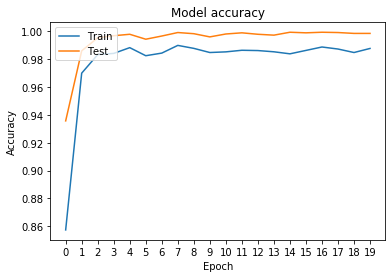

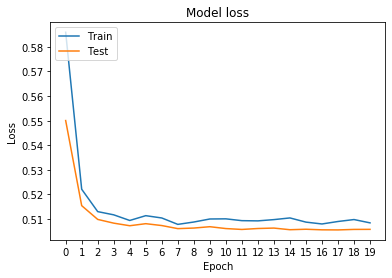

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(loc)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(loc)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()